This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

--2021-12-03 19:27:56--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2021-12-03 19:27:56--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc10dca58c1d2cab1cd00e2f9ef.dl.dropboxusercontent.com/cd/0/inline/BbJykpadpdJ4Mhig49PrHyGoN5DrbLzvbQ35CpAMr_R86A2Wtcrkg9NK3RGc9txNg08TQzZo7R5K0SYg4wRBCYP1zN2iGfJOs9Pd4D_TKt934kRMu-XiXBG_DCbB_2oE4d4c8EiDcLg2nJjugNdB8SQW/file# [following]
--2021-12-03 19:27:56--  https://ucc10dca58c1d2cab1cd00e2f9ef.dl.dropboxusercontent.com/cd/0/inline/BbJykpadpdJ4Mhig49PrHyGoN5DrbLzvbQ35CpAMr_R86A2Wtcrkg9NK3RGc9txNg08TQzZo7R5K0SYg4

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd
import numpy as np


path = "/content/data/data_000637.txt"
data = pd.read_csv(path, sep=",", header=0)
max_row = data.shape[0]
N = np.random.randint(10000, max_row)
data = data[:N]
data.shape

(1256498, 6)

2\. Estimate the number of BX in a ORBIT (the value 'x').

In [3]:
BX = data.groupby("ORBIT_CNT")["BX_COUNTER"].max()
BX

ORBIT_CNT
3869200167    3187
3869200168    3538
3869200169    2766
3869200170    3377
3869200171    3542
              ... 
3869210799    3411
3869210800    3562
3869210801    3530
3869210802    3435
3869210803    2410
Name: BX_COUNTER, Length: 10633, dtype: int64

3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [4]:
import datetime


def trans(t):
  return datetime.timedelta(seconds=t)


x = data['ORBIT_CNT']*data['BX_COUNTER']*25 + data['BX_COUNTER']*25 + data['TDC_MEAS']*25/30
x = x*10**-9
x = x.apply(trans)

print('Estimated Duration of data taking : ')
print(x.max())

Estimated Duration of data taking : 
3 days 23:44:09.950139


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [5]:
data['duration'] = data['ORBIT_CNT']*data['BX_COUNTER']*25 + data['BX_COUNTER']*25 + data['TDC_MEAS']*25/30
data['duration'] = data['duration'] * 10 ** -9
data.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,duration
0,1,0,123,3869200167,2374,26,229637.029971
1,1,0,124,3869200167,2374,27,229637.029971
2,1,0,63,3869200167,2553,28,246951.700723
3,1,0,64,3869200167,2558,19,247435.350744
4,1,0,64,3869200167,2760,25,266974.811592


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
print(data.groupby(['TDC_CHANNEL'])['HEAD'].count().sort_values(ascending=False)[:3])

TDC_CHANNEL
139    103605
64      63293
63      61971
Name: HEAD, dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [7]:
data.groupby('ORBIT_CNT')['HEAD'].count()

ORBIT_CNT
3869200167     43
3869200168     85
3869200169    127
3869200170     98
3869200171    109
             ... 
3869210799    155
3869210800    196
3869210801    149
3869210802    151
3869210803    141
Name: HEAD, Length: 10633, dtype: int64

In [8]:
data[data['TDC_CHANNEL'] == 139].groupby(['ORBIT_CNT','TDC_CHANNEL'])['HEAD'].count()

ORBIT_CNT   TDC_CHANNEL
3869200167  139             4
3869200168  139             8
3869200169  139            11
3869200170  139             9
3869200171  139             9
                           ..
3869210799  139            15
3869210800  139            18
3869210801  139            14
3869210802  139            11
3869210803  139            14
Name: HEAD, Length: 10608, dtype: int64

7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

In [9]:
import matplotlib.pyplot as plt

fpga0 = data[data['FPGA'] == 0].groupby('TDC_CHANNEL')['HEAD'].count()
fpga1 = data[data['FPGA'] == 1].groupby('TDC_CHANNEL')['HEAD'].count()

Text(0, 0.5, 'NUMBER OF HIT')

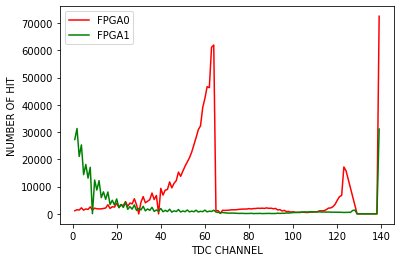

In [10]:
fig, ax = plt.subplots()

ax.plot(fpga0, color='r', label='FPGA0')
ax.plot(fpga1,  color='g', label='FPGA1')
plt.legend()
ax.set_xlabel('TDC CHANNEL')
ax.set_ylabel('NUMBER OF HIT')